# Sign Language digit classifier

This notebook guides through the process of classifying sign language digits. It utilises a Convolutional Neural Network architecture built with Keras library. The purpose of this notebook is to showcase an examplary workflow when dealing with simple computer-vision based tasks.

## Introduction

In [28]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

import keras
from keras.models import Sequential
from keras.layers import Activation, Conv2D, MaxPool2D, Dense, Flatten, Dropout
from keras.layers.normalization import BatchNormalization
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

DATA_PATH = "data/data.npy"
LABELS_PATH = "data/labels.npy"

In [29]:
RAND_SEED = 7
BATCH_SIZE = 96
EPOCHS = 50
LEARNING_RATE = 0.0002
DECAY = 1e-6

Let's load in our data and explore it a little bit.

In [30]:
X = np.load(DATA_PATH)
y = np.load(LABELS_PATH)

X.shape, y.shape

((2062, 64, 64), (2062, 10))

There are 2062 images in our dataset, each the size of 64x64 pixels. Every image has a corresponding label; there are 10 different classes in our data, making it a multiclass (multinominal) classification problem.

For now, our dataset looks like this:

In [31]:
print(f"First image:\n {X[0]} \nfirst label:\n {y[0]}")

First image:
 [[0.47450978 0.46274507 0.45098037 ... 0.50196075 0.5137255  0.52549016]
 [0.46666664 0.45098037 0.43921566 ... 0.4980392  0.5098039  0.52156866]
 [0.45490193 0.43921566 0.42745095 ... 0.49411762 0.50196075 0.517647  ]
 ...
 [0.4470588  0.4352941  0.4235294  ... 0.49019605 0.4980392  0.5058824 ]
 [0.45490193 0.44313723 0.43137252 ... 0.4980392  0.5058824  0.5137255 ]
 [0.46274507 0.45098037 0.43921566 ... 0.50196075 0.5098039  0.52156866]] 
first label:
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


Looks like our images are already normalised (values between 0 and 1) but the labels are one-hot-encoded.

Let's check out the class distribution in our dataset.

In [32]:
unique, count = np.unique(np.argmax(y, axis=1), return_counts=True)
occurences = dict(zip(unique, count))
print(f"The number of occurences of each class in the dataset = \n{occurences}")

The number of occurences of each class in the dataset = 
{0: 205, 1: 206, 2: 206, 3: 206, 4: 207, 5: 207, 6: 207, 7: 206, 8: 208, 9: 204}


So far, so good; all the classes in our dataset are evenly distributed.

## Data visualisation

Let's prepare some visualisations to better understand our data, we'll start with a random sample of our dataset. Since we'll randomly reorder our data a couple of times, we can write a function for that aswell.

In [33]:
def shuffle_data(image_data, label_data, random_seed):
    return np.random.RandomState(random_seed).permutation(image_data), np.random.RandomState(random_seed).permutation(label_data)

def display_rand_imgs(image_data, label_data, random_seed):
    images, labels = shuffle_data(image_data, label_data, random_seed)
    
    fig, axes = plt.subplots(5, 5, figsize = (15,15))
    plt.suptitle("Random images and their labels", fontsize=18)
    for row in axes:
        for axis in row:
            index = np.random.randint(random_seed)
            image = images[index].reshape(64, 64)
            label = np.argmax(labels[index])
            axis.imshow(image, cmap='binary')
            axis.set_title(f"Number {label}")
            axis.set_axis_off()        

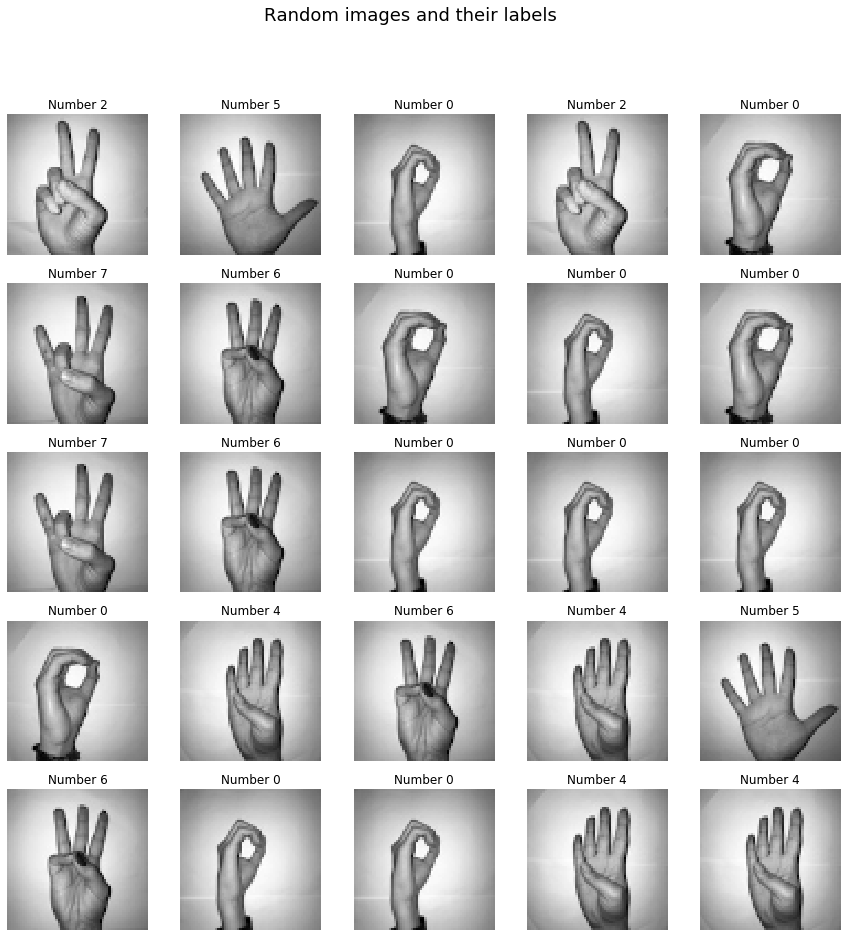

In [34]:
display_rand_imgs(X, y, RAND_SEED)

## Data preprocessing

In general, when dealing with images, the data preprocessing workflow consists of:
- randomly reordering data within the dataset
- splitting the data into train and test sets (and sometimes a validation set)
- reshaping the images
- pixel value normalisation
- one-hot encoding

Let's start with first two steps. Since scikit already has a good method for doing both at once, we'll use that. We can also use our own method, since it's always better to shuffle the data multiple times than not to shuffle it at all.

In [35]:
X, y = shuffle_data(X, y, RAND_SEED+10)

Let's see the randomised data

In [36]:
np.argmax(y[:10], axis=1)

array([3, 6, 3, 3, 0, 7, 5, 5, 0, 8], dtype=int64)

Time to split the data; we'll also check data shape.

In [37]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = RAND_SEED)

In [38]:
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((1649, 64, 64), (413, 64, 64), (1649, 10), (413, 10))

Now we have to reshape the data to feed it into our neural network. In addition to our image shape, we also need to specify one extra dimension for Keras library for the color channels. 

Since we operate on greyscale images, we will add 1 as the last dimension. In case of color images, we would add 3 as the channel (for Red, Green and Blue). In general, we can also specify the first dimension as -1 and NumPy will figure it out on its own.

In [39]:
x_train = x_train.reshape(-1, 64, 64, 1).astype('float32')
x_test = x_test.reshape(-1, 64, 64, 1).astype('float32')

In [40]:
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((1649, 64, 64, 1), (413, 64, 64, 1), (1649, 10), (413, 10))

At this point, we would usually normalise our images for the values to range between 0 and 1 for each pixel, but with this dataset, it has already been done for us, but we can double check.

In [41]:
print(f"Our values before normalisation \n {x_train[0]*255} \nand after normalisation \n {x_train[0]}")

Our values before normalisation 
 [[[131.99998]
  [129.     ]
  [125.99999]
  ...
  [143.     ]
  [145.99998]
  [149.     ]]

 [[129.     ]
  [125.99999]
  [122.99999]
  ...
  [141.99998]
  [145.     ]
  [147.     ]]

 [[125.99999]
  [122.99999]
  [119.99999]
  ...
  [139.     ]
  [141.99998]
  [145.     ]]

 ...

 [[123.99999]
  [120.99999]
  [118.99999]
  ...
  [139.99998]
  [141.99998]
  [145.     ]]

 [[126.99999]
  [122.99999]
  [119.99999]
  ...
  [141.     ]
  [143.99998]
  [145.99998]]

 [[129.     ]
  [126.99999]
  [123.99999]
  ...
  [143.     ]
  [145.     ]
  [147.99998]]] 
and after normalisation 
 [[[0.517647  ]
  [0.5058824 ]
  [0.49411762]
  ...
  [0.56078434]
  [0.572549  ]
  [0.58431375]]

 [[0.5058824 ]
  [0.49411762]
  [0.4823529 ]
  ...
  [0.5568627 ]
  [0.5686275 ]
  [0.5764706 ]]

 [[0.49411762]
  [0.4823529 ]
  [0.4705882 ]
  ...
  [0.54509807]
  [0.5568627 ]
  [0.5686275 ]]

 ...

 [[0.48627448]
  [0.47450978]
  [0.46666664]
  ...
  [0.5490196 ]
  [0.5568627 ]


Values are divided by 255 in order to normalise them since each pixel is represented as a value between 0 and 255 - it describes pixel's color intensity.

Last step in data preprocessing is to one-hot encode the labels for our images - like with normalisation, it had already been done by the dataset owner.

In [42]:
print(f"Label value for 1st(0th) element before one-hot encoding \n {np.argmax(y_train[0])} \nand after one-hot encoding \n {y_train[0]}")

Label value for 1st(0th) element before one-hot encoding 
 4 
and after one-hot encoding 
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]


We can see how the 4th (starting from 0) value has a 1 and all the other values are 0 and it matches our decoded value.

## Building our model

Now, it's time to build our Convolutional Neural Network.

In [43]:
model = Sequential()

model.add(Conv2D(16, (3, 3), input_shape=x_train.shape[1:]))
model.add(Activation("relu"))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
# model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Dropout(0.2))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Dropout(0.2))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Flatten())

model.add(Dense(64))
model.add(Activation("relu"))

model.add(Dense(10))
model.add(Activation("softmax")) 

In [44]:
opt = keras.optimizers.Adam(lr=LEARNING_RATE, decay=DECAY)

model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

In [45]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 62, 62, 16)        160       
_________________________________________________________________
activation_16 (Activation)   (None, 62, 62, 16)        0         
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 31, 31, 16)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 29, 29, 32)        4640      
_________________________________________________________________
activation_17 (Activation)   (None, 29, 29, 32)        0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 29, 29, 32)        0         
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 14, 14, 32)        0         
__________

The model we built is relatively simple, but this is an easy task, so there's no need for a complex model. 

## Training a Convolutional Neural Network

Time to train our model. We'll use 20% of our train set as a validation set to keep track of our progress.

In [46]:
hist = model.fit(x_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCHS, validation_split=0.2)

Train on 1319 samples, validate on 330 samples
Epoch 1/50
1319/1319 [==============================] - 6s 4ms/step - loss: 2.1040 - acc: 0.3017 - val_loss: 1.7324 - val_acc: 0.5030
Epoch 2/50
1319/1319 [==============================] - 4s 3ms/step - loss: 1.2816 - acc: 0.6141 - val_loss: 1.2289 - val_acc: 0.7182
Epoch 3/50
1319/1319 [==============================] - 4s 3ms/step - loss: 0.8997 - acc: 0.7331 - val_loss: 0.9254 - val_acc: 0.7485
Epoch 4/50
1319/1319 [==============================] - 4s 3ms/step - loss: 0.6892 - acc: 0.8021 - val_loss: 0.8111 - val_acc: 0.7667
Epoch 5/50
1319/1319 [==============================] - 4s 3ms/step - loss: 0.5878 - acc: 0.8279 - val_loss: 0.7327 - val_acc: 0.7818
Epoch 6/50
1319/1319 [==============================] - 4s 3ms/step - loss: 0.5100 - acc: 0.8469 - val_loss: 0.6495 - val_acc: 0.7970
Epoch 7/50
1319/1319 [==============================] - 4s 3ms/step - loss: 0.4547 - acc: 0.8681 - val_loss: 0.6142 - val_acc: 0.8273
Epoch 8/50
1319

## Evaluating the model

Let's take a look at our accuracy and loss curves.

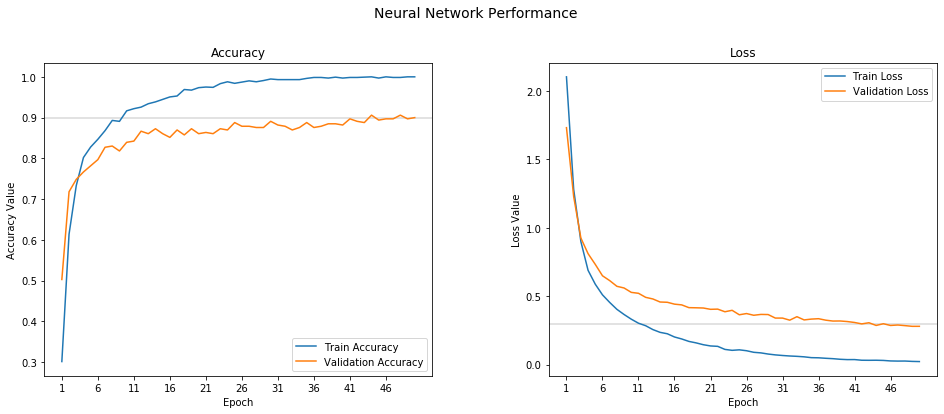

In [47]:
figure, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
title = figure.suptitle('Neural Network Performance', fontsize=14)
figure.subplots_adjust(top=0.85, wspace=0.3)

epoch_list = list(range(1, 51))
ax1.axhline(y=0.9, color="0.85")
ax1.plot(epoch_list, hist.history['acc'], label='Train Accuracy')
ax1.plot(epoch_list, hist.history['val_acc'], label='Validation Accuracy')
ax1.set_xticks(np.arange(1, 51, 5))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.axhline(y=0.3, color="0.85")
ax2.plot(epoch_list, hist.history['loss'], label='Train Loss')
ax2.plot(epoch_list, hist.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(1, 51, 5))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

Our model's accuracy is around 90% and the loss is around 0.3, indicated by light gray lines on both graphs. Both train and validation accuracy curves are relatively close to each other, thus we can deduce that the model doesn't overfit to our train data.

Let's see how the model performs on never seen before data: 

In [48]:
val_loss, val_acc = model.evaluate(x_test, y_test)
score = model.evaluate(x_test, y_test, verbose=0)
print(f'Test loss: {score[0]}')
print(f'Test accuracy: {score[1]}')

413/413 [==============================] - 0s 857us/step
Test loss: 0.3139052214619611
Test accuracy: 0.8958837788272423


The model does only slightly worse on the data it sees for the first time, which is really good. Now we're absolutely sure the model doesn't overfit. 

Let's take a look at the confusion matrix to understand where the model did poorly.

Text(0.5, 51.0, 'Predicted labels')

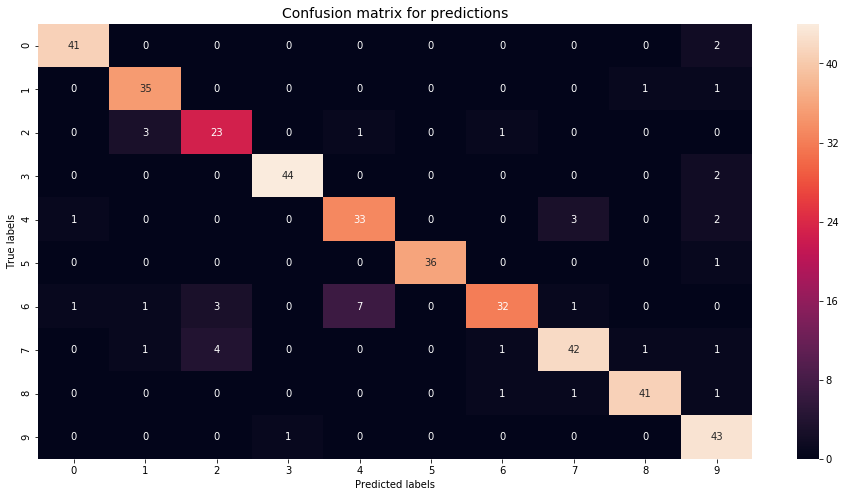

In [49]:
prediction = model.predict(x_test)
predicted_labels = np.argmax(prediction, axis=1)
test_labels = np.argmax(y_test, axis=1)

cm = confusion_matrix(test_labels, predicted_labels)
plt.figure(figsize=(16,8))
ax = sns.heatmap(cm,annot=True)

#fix for matplotlib 3.1.1 and broken seaborn heatmaps
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.title("Confusion matrix for predictions", fontsize=14)
plt.ylabel('True labels')
plt.xlabel('Predicted labels')

Interestingly, our model had some problems differentiating between 6 and 4, as well as misclassifying 6s and 7s as 2s and it should be apparent in the classification report below.

In [50]:
print(classification_report(test_labels, predicted_labels))

              precision    recall  f1-score   support

           0       0.95      0.95      0.95        43
           1       0.88      0.95      0.91        37
           2       0.77      0.82      0.79        28
           3       0.98      0.96      0.97        46
           4       0.80      0.85      0.83        39
           5       1.00      0.97      0.99        37
           6       0.91      0.71      0.80        45
           7       0.89      0.84      0.87        50
           8       0.95      0.93      0.94        44
           9       0.81      0.98      0.89        44

    accuracy                           0.90       413
   macro avg       0.90      0.90      0.89       413
weighted avg       0.90      0.90      0.90       413



Our model suffers from: 
- low precision for digit number 2, meaning predicted 2s aren't actually 2s,
- low recall for digit number 6, meaning it has problems with predicting actual 6s. 

## Visualising predictions

Time to visualise correct and incorrect predictions. For this purpose, we'll organise correct and incorrect predictions and create a simple method to plot them.

In [51]:
correct = []
incorrect = []

for i in range(len(y_test)):
    if(predicted_labels[i] == test_labels[i]):
        correct.append(i)
    elif(predicted_labels[i] != test_labels[i]):
        incorrect.append(i)

In [54]:
def plot_predictions(pred_list, pred_string):
    fig, axes = plt.subplots(2, 5, figsize = (16,8))
    plt.suptitle(f"{pred_string} predictions", fontsize=18)
    for row in axes:
        for axis in row:
            index = np.random.randint(RAND_SEED)
            axis.imshow(x_test[pred_list[index]].reshape(64,64), cmap='binary')
            axis.set_title(f"Predicted Label : {predicted_labels[pred_list[index]]} \n Actual Label : {test_labels[pred_list[index]]}")
            axis.set_axis_off()   

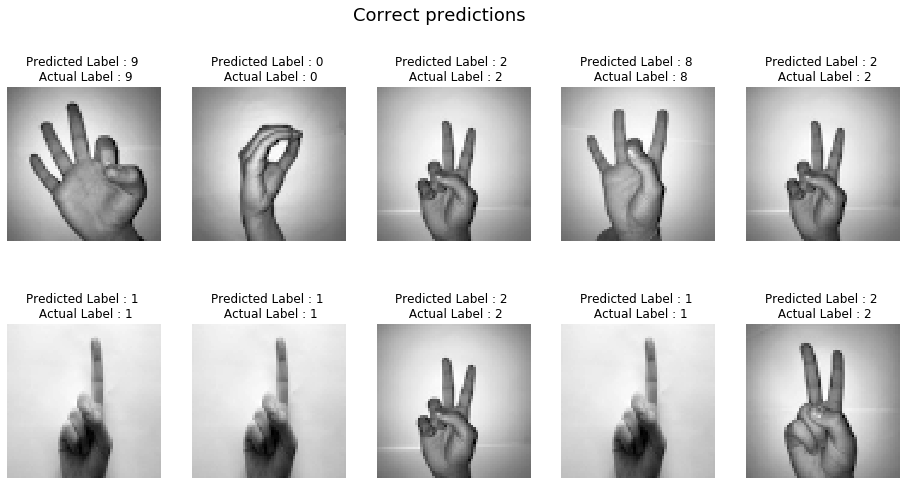

In [55]:
plot_predictions(correct, "Correct")

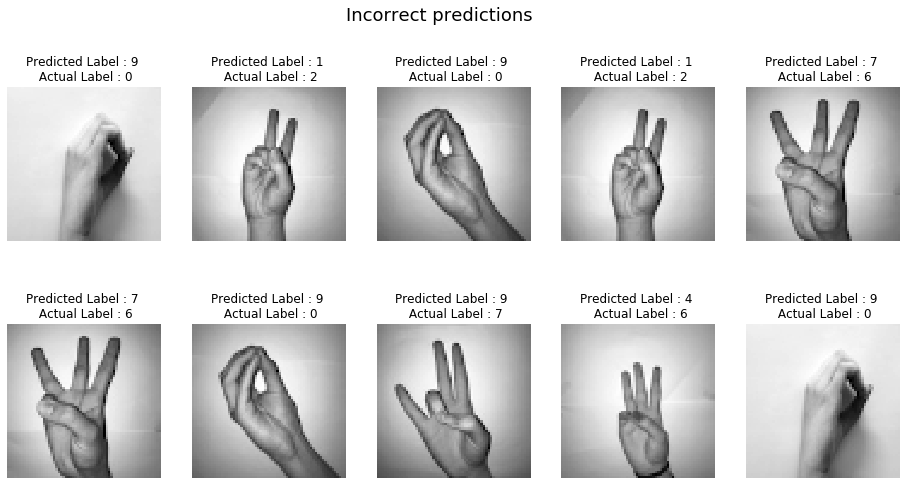

In [56]:
plot_predictions(incorrect, "Incorrect")

## Conclusions

In conclusion, we explored sign language digit dataset, created an effcient model that boasts an average accuracy of around 89% and performed some model evaluation to assess how good it actually is and where are it's shortcomings.